## Customer Segmentation using K-Means Clustering

The dateset used in this Cluster Analysis can be found <a href="https://www.kaggle.com/vijayuv/onlineretail">here</a>

The steps taken in this project are:
* **Data Cleaning**
* **Create RFM Table**
* **Manage Skew**
* **Standardize Variables**
* **Clustering - using KMeans**
    - Plot Screeplot
    - Calculate Silhouette score
    - Clustering
* **Segment Visualization**
* **Model Observations**
* **Segmenting Customers**
Identify Cluster characteristics and segment into
    - Low Value Customers
    - New Customers
    - Mid Value Customers
    - High Value Customers
* **Segment Analysis**
* **Conclusion**
    - Takeaways and Way forward



In [145]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [112]:
df = pd.read_csv('OnlineRetail.csv',  encoding= 'unicode_escape')

In [113]:
df.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
99553,544776,21668,RED STRIPE CERAMIC DRAWER KNOB,2,23-02-2011 11:39,2.46,NaN,United Kingdom
519081,580136,21935,SUKI SHOULDER BAG,2,01-12-2011 19:42,1.65,17841.0,United Kingdom


In [114]:
df.shape

(541909, 8)

In [115]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## Data Cleaning

In [116]:
df.isnull().values.any()

True

In [117]:
#df_null = round(100*(retail.isnull().sum())/len(retail), 2)

#### Removing entries with null CustomerID

In [118]:
df = df[df['CustomerID'].notna()] #df[df['CustomerID'].isna()]
df.shape

(406829, 8)

#### Change InvoiceDate to date dataype

In [119]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

#### Check if quantity is positive value else remove

In [120]:
df[df['Quantity']<=0].sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
421963,C573034,22690,DOORMAT HOME SWEET HOME BLUE,-1,2011-10-27 13:41:00,8.25,14227.0,United Kingdom
164499,C550648,22558,CLOTHES PEGS RETROSPOT PACK 24,-2,2011-04-19 16:36:00,1.65,13134.0,United Kingdom


In [121]:
df = df[df['Quantity']>0]

#### Calculate TotalPrice from Quantity and UnitPrice

In [122]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
376719,569533,23515,EMBROIDERED RIBBON REEL DAISY,1,2011-04-10 15:21:00,2.08,16374.0,United Kingdom,2.08
38297,539498,85034C,3 ROSE MORRIS BOXED CANDLES,12,2010-12-20 10:48:00,1.25,15279.0,United Kingdom,15.00


## Create Recency Frequency Monetary value Table

In [123]:
import datetime
snapshot_date = max(df['InvoiceDate']) + datetime.timedelta(days=1)
snapshot_date

#Aggregate by CustomerID
customers = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x:(snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

customers.rename(columns= {'InvoiceDate' : 'Recency',
                          'InvoiceNo' : 'Frequency',
                          'TotalPrice' : 'Monetary'}, inplace=True)
customers.sample(2)

,Recency,Frequency,Monetary
CustomerID,,,
16596.0,17,12,250.15
18006.0,25,22,444.68


## Manage Skewness

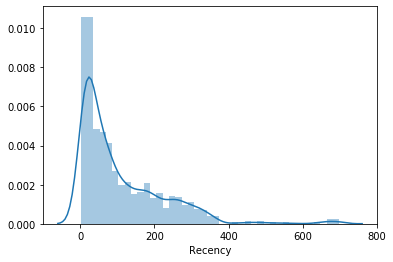

In [124]:
#Visualization of each variable
sns.distplot(customers.Recency)

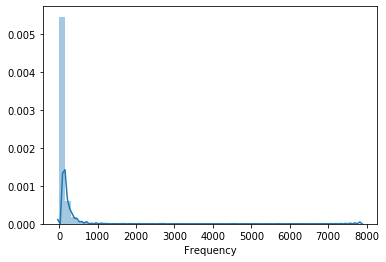

In [125]:
sns.distplot(customers.Frequency)

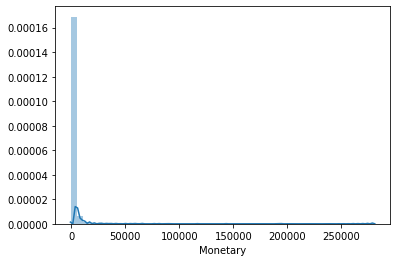

In [126]:
sns.distplot(customers.Monetary)

#### Highly skewed distribution is observed for all three variables, this can be rectified by applying one of the transformations on the data.
 - Log Transformation
 - SquareRoot Transformation
 - Cube Transformation
 - Box-Cox Transformation

In [127]:
#Skew Values on the variables
print(customers.Recency.skew())
print(customers.Frequency.skew())
print(customers.Monetary.skew())

1.9175159984488952
18.106242903118684
19.326985305561827


#### Log Transformation

-0.6547244680673008
-0.22015490308024482
nan


/Users/haripriya/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


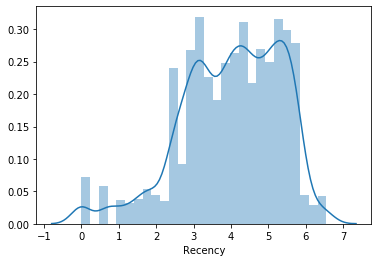

In [128]:
recency_log = np.log(customers.Recency)
frequency_log = np.log(customers.Frequency)
monetary_log = np.log(customers.Monetary)
print(recency_log.skew())
print(frequency_log.skew())
print(monetary_log.skew())
sns.distplot(recency_log)

#### Square Root Transformation

0.6969867632799238
3.2228655181183483
5.886428106945661


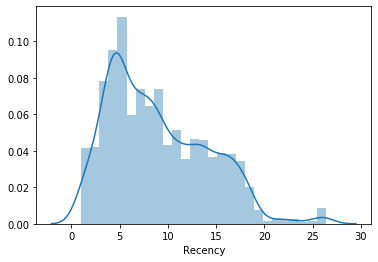

In [129]:
recency_sqrt = np.sqrt(customers.Recency)
frequency_sqrt = np.sqrt(customers.Frequency)
monetary_sqrt = np.sqrt(customers.Monetary)
print(recency_sqrt.skew())
print(frequency_sqrt.skew())
print(monetary_sqrt.skew())
sns.distplot(recency_sqrt)

#### Cube Root Transformation

0.31240733935389847
1.5139956026003647
2.996715482799713


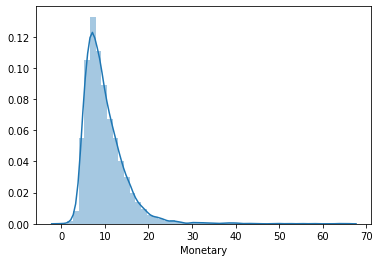

In [130]:
recency_cbrt = np.cbrt(customers.Recency)
frequency_cbrt = np.cbrt(customers.Frequency)
monetary_cbrt = np.cbrt(customers.Monetary)
print(recency_cbrt.skew())
print(frequency_cbrt.skew())
print(monetary_cbrt.skew())
sns.distplot(monetary_cbrt)

#### Box Cox Transformation

-0.05129871179645878
0.004197415222226033


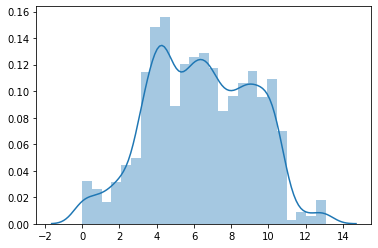

In [131]:
from scipy import stats
recency_boxcox = stats.boxcox(customers.Recency)[0]
frequency_boxcox = stats.boxcox(customers.Frequency)[0]
print(pd.Series(recency_boxcox).skew())
print(pd.Series(frequency_boxcox).skew())
sns.distplot(recency_boxcox)

#### Observations:
- Monetary value data is not positive, hence CubeRoot Transformation is used for it
- BoxCox Transformation shows least skew(nearer to zero) for Recency and Frequency 

In [132]:
customers_fix = pd.DataFrame()
customers_fix['CustomerID'] = customers.index
customers_fix['Recency'] = stats.boxcox(customers.Recency)[0]
customers_fix['Frequency'] = stats.boxcox(customers.Frequency)[0]
customers_fix['Monetary'] = pd.Series(np.cbrt(customers['Monetary'])).values
customers_fix

,CustomerID,Recency,Frequency,Monetary
0,12346.0,10.594460,0.000000,42.576995
1,12347.0,5.408713,5.973859,16.273929
2,12348.0,6.771296,3.758729,12.158183
3,12349.0,4.044175,4.805208,12.068017
4,12350.0,10.453001,3.051922,6.941001
...,...,...,...,...
4334,18280.0,8.589243,2.445694,5.652483
4335,18281.0,1.884613,2.047477,4.323541
4336,18282.0,9.400988,2.652113,5.625753
4337,18283.0,3.042330,7.909634,12.795376


## Scaling the data

In [133]:
customers_scaled = pd.DataFrame()
customers_scaled['Recency'] = preprocessing.scale(customers_fix['Recency'])
customers_scaled['Frequency'] = preprocessing.scale(customers_fix['Frequency'])
customers_scaled['Monetary'] = preprocessing.scale(customers_fix['Monetary'])
customers_scaled

,Recency,Frequency,Monetary
0,1.543469,-2.568435,6.608337
1,-0.343482,1.166124,1.291771
2,0.152324,-0.218665,0.459867
3,-0.840000,0.435542,0.441642
4,1.491995,-0.660525,-0.594668
...,...,...,...
4334,0.813825,-1.039509,-0.855112
4335,-1.625805,-1.288454,-1.123727
4336,1.109197,-0.910466,-0.860515
4337,-1.204544,2.376274,0.588661


---

# CLUSTERING - K means

---

[0.38691624554410403, 0.4451206934889974, 0.4367579299861093]


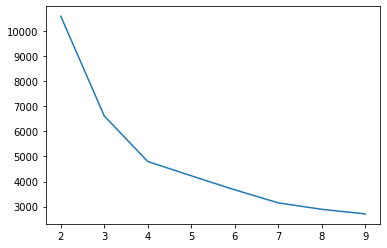

In [183]:
sse={}
silhouette_avg=[]
for k in range(2,10):
    new_model = cluster.KMeans(n_clusters=k).fit(customers_scaled)
    sse[k] = new_model.inertia_
    silhouette_avg.append(silhouette_score(customers_scaled, new_model.labels_))
    
plt.plot(list(sse.keys()),list(sse.values()))
print(silhouette_avg[0:3])


#### Sihouette scores

Silhouette Score for 2 clusters: 0.38691<br>
Silhouette Score for 3 clusters: 0.4451<br>
Silhouette Score for 4 clusters: 0.43675

#### Sihouette score is higher for 3 clusters which makes it a good choice as also observed from the elbow method on the scree plot, but 4 clusters seems more apt to factor the different customer characteristics
<br><br>

In [176]:
model = cluster.KMeans(n_clusters=4, random_state=3).fit(customers_scaled.values)
customers_scaled['SegmentClusters'] = model.labels_
customers_scaled

,Recency,Frequency,Monetary,SegmentClusters
0,1.543469,-2.568435,6.608337,0
1,-0.343482,1.166124,1.291771,3
2,0.152324,-0.218665,0.459867,3
3,-0.840000,0.435542,0.441642,3
4,1.491995,-0.660525,-0.594668,1
...,...,...,...,...
4334,0.813825,-1.039509,-0.855112,1
4335,-1.625805,-1.288454,-1.123727,2
4336,1.109197,-0.910466,-0.860515,1
4337,-1.204544,2.376274,0.588661,3


---

# SEGMENT VISUALIZATION

In [177]:
customers_scaled.sample(5)

,Recency,Frequency,Monetary,SegmentClusters
1947,1.566838,-0.218665,-0.397412,1
3625,0.681214,-0.800406,-0.251861,1
2895,-0.748597,0.815271,0.650587,3
4038,0.877778,-0.910466,-0.745704,1
3543,-1.106839,0.545551,0.736197,3


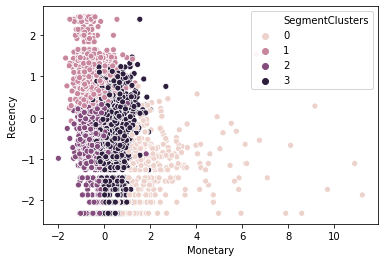

In [178]:
sns.scatterplot(data=customers_scaled, x='Monetary',y='Recency', hue='SegmentClusters')

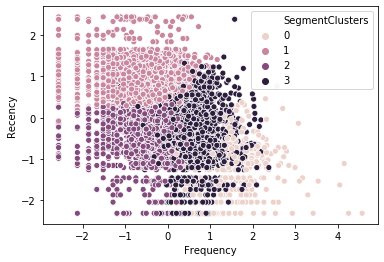

In [179]:
sns.scatterplot(data=customers_scaled, x='Frequency',y='Recency', hue='SegmentClusters')

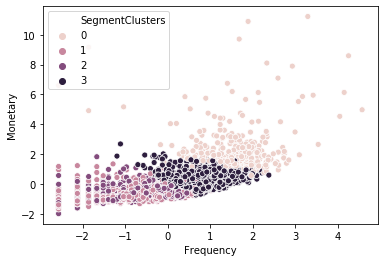

In [180]:
sns.scatterplot(data=customers_scaled, x='Frequency',y='Monetary', hue='SegmentClusters')

In [181]:
customers_scaled.groupby('SegmentClusters')['Recency','Frequency','Monetary'].mean()

/Users/haripriya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Recency,Frequency,Monetary
SegmentClusters,,,
0,-1.122195,1.578075,2.274971
1,1.095918,-0.687339,-0.586368
2,-0.471877,-0.577667,-0.491189
3,-0.462483,0.717790,0.387207


In [182]:
customers_scaled['SegmentClusters'].value_counts()

3    1468
1    1444
2    1073
0     354
Name: SegmentClusters, dtype: int64

---

# MODEL OBSERVATIONS

* **There is quite some overlap between the clusters and no clear boundaries exist with the use of the RFM model**
<br><br>
* **The Mean values of the features across the clusters also do not show a cear variance in the values**
<br><br>
* **The cluster size also vary greatly with just 354 customers in cluster 0 as opposed to 1468 in cluster 2**
<br><br>
* **The RFM model was analysed with 3 cluster size as well but the clusters were too big to classify customer traits efficiently**
<br><br>

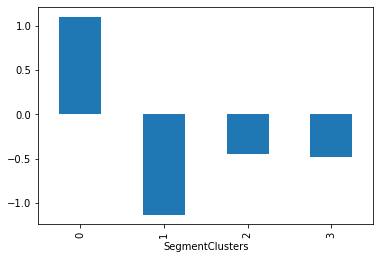

In [142]:
r=customers_scaled.groupby('SegmentClusters')['Recency'].mean()
r.plot(kind='bar')

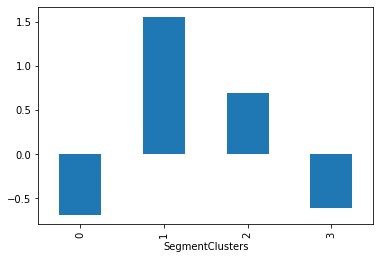

In [143]:
r=customers_scaled.groupby('SegmentClusters')['Frequency'].mean()
r.plot(kind='bar')

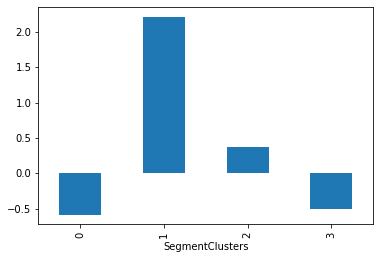

In [144]:
r=customers_scaled.groupby('SegmentClusters')['Monetary'].mean()
r.plot(kind='bar')

---

# SEGMENTING CUSTOMERS

### Cluster 0 - High Value Customer
<br>
Customers that have a high Recency, high Frequency and High Monetary value fall in this category. They are the regular customers who add much to the Sales of the store.
<br>


### Custer 1 - Low Value Customer
<br>
Customers particularly characterised by low Frequency, low Recency and low Monetary value fall in this category. This may signify customers who came to the store for few purchases and are not returning to the stores. 
<br>
Interestingly, this cluster can be further subdivided to identify non-returning customers and low-value customers. Low value customers would have the lowest Recency and Frequency while Non returning customers would be on the higher end with higer frequency and monetary vaue indicating past purchases but lacking Recency. The RFM model clusters identified here are unable to capture that.
<br>

### Cluster 2 - New Customers
<br>
Customers with High Recency and moderate frequency and monetary value can be identified as New Customers. They have started visiting the store recently since their recency is higher and frequency is moderate which may signify potentially climbing values. Since they are new they havn't yet contributed a lot to the Sales.
<br>

### Custer 3 - Mid Value Customers
<br>
Customers with moderate values on Recency, Frequency and Monetary value are falling under this category
<br>



---

# CONCLUSION

- KMeans Clustering is suited for naturally occuring circular clusters in 2D visualisation, which is absent in the present model.
<br>
- Here the points lie closer together and the RFM model used fails to show insight into the segments and their characteristics
<br>


### Takeaways and Way Forward

- Here, the RFM model doesn't capture the segments cleary
<br>
- Try another model, with more engineered variables for the analysis
<br>
- Implement PCA to obtain PC's with high variance in data
<br>
- Try Other Clustering Algorithms and Compare the results
<br>